# Test pour l'utilisation d'un classifieur non supervisé

L'idée provient du fait que la CSP permet de bien discriminer les epochs correspondant à du mouvement de celles correspondant à du non mouvement.

Ce notebook montre de bons résultats quand une pipeline est entrainée sur un patient et utilisée sur l'autre session du même patient. 

L'utilisation d'un classifieur non-supervisé semble cependant non adaptée à notre situation. En effet, nous avons besoin de prédire l'intention de mouvement ou non sur une unique petite fenêtre temporelle ou époque alors que l'utilisation d'algorithmes comme Kmeans requièrent un ensemble de ces objects. 


# 1 - Chargement des modules et des données

In [1]:
from preprocessing import DataLoader

import mne
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm

In [2]:
# Filtering bounds
FILTER_FMIN = 4
FILTER_FMAX = 40

# Epoching bounds
EPOCHS_TMIN = -1.5
EPOCHS_TMAX = +1.5
EPOCHS_TMIN_NO_ONSET = -5.0
EPOCHS_TMAX_NO_ONSET = EPOCHS_TMIN_NO_ONSET + EPOCHS_TMAX - EPOCHS_TMIN

# Set seed
RANDOM_STATE = 42

BINARY_CLASSIFICATION = True

In [ ]:
NB_SESSIONS = 10

FOLDER_PATH = '../../data/raw/'
FILES_PATHS = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

# Show paths
FILES_PATHS

In [4]:
def get_channels(raws, side):
    endings = ('1', '3', '5', '7', '9') if side=='D' else ('2', '4', '6', '8', '10')
    channels_to_remove = [channel for channel in raws.ch_names if channel.endswith(endings)]
    channels = [channel for channel in raws.ch_names if channel not in channels_to_remove]
    return channels

In [5]:
def preproc(file_list, verbose=False, return_epochs=False):
    patients_data   = []
    patients_labels = []
    patients_id = []
    sessions_id = []
    patients_epochs = []

    for fid in tqdm.tqdm(file_list):

        # Load the data
        data_loader = DataLoader(fid)

        # Pick the arm session opposite to the stroke side
        stroke_side = data_loader.stroke_side
        side = 'G' if stroke_side == 'D' else 'D'
        raws = data_loader.get_raws(side)

        # if no data for the arm side, skip
        if raws is None:
            continue

        # Pick the channels of the stroke side
        raws.pick_channels(get_channels(raws, stroke_side))

        # Filter between 4Hz - 48Hz
        raws.filter(FILTER_FMIN, FILTER_FMAX, fir_design='firwin')

        # Epochs over flexion and extension
        events = mne.find_events(raws, stim_channel=['movement'])
        picks  = mne.pick_types(raws.info, eeg=True, stim=False)
        epochs = mne.Epochs(raws, events, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, picks=picks, baseline=None, preload=True)

        epochs_X = epochs.get_data()  # data
        epochs_y = events[:, -1]      # labels

        # Epochs of no movement artificially created
        epochs_no_onset = mne.Epochs(raws, events, tmin=EPOCHS_TMIN_NO_ONSET, tmax=EPOCHS_TMAX_NO_ONSET, picks=picks, baseline=None, preload=True)

        epochs_no_onset_X = epochs_no_onset.get_data()           # data
        epochs_no_onset_y = np.zeros(epochs_no_onset_X.shape[0]) # labels

        # Concatenate epochs
        epochs_X_session = np.concatenate([epochs_X, epochs_no_onset_X], axis=0)
        epochs_y_session = np.concatenate([epochs_y, epochs_no_onset_y], axis=0)

        # Create epochs object
        events_no_onset = events.copy()
        events_no_onset[:, 2] = 0
        events_no_onset[:, 0] = events_no_onset[:,0] - int((EPOCHS_TMAX-EPOCHS_TMIN) * raws.info['sfreq'])

        events_all = np.concatenate([events, events_no_onset], axis=0)
        epochs_all = mne.EpochsArray(
            epochs_X_session,
            epochs.info,
            events=events_all,
            tmin=epochs.tmin,
            )

        # Shuffle epochs
        rng = np.random.RandomState(RANDOM_STATE)
        idx = np.arange(epochs_X_session.shape[0])
        rng.shuffle(idx)
        epochs_X_session = epochs_X_session[idx]
        epochs_y_session = epochs_y_session[idx]

        # Merge flexion and extension if needed
        if BINARY_CLASSIFICATION:
            epochs_y_session[epochs_y_session > 0] = 1

        # Append to the list
        if data_loader.patient_id not in patients_id:
            patients_id.append(data_loader.patient_id)
            sessions_id.append([])
            patients_data.append([])
            patients_labels.append([])
            patients_epochs.append([])
        sessions_id[patients_id.index(data_loader.patient_id)].append(data_loader.session_id)
        patients_data[patients_id.index(data_loader.patient_id)].append(epochs_X_session)
        patients_labels[patients_id.index(data_loader.patient_id)].append(epochs_y_session)
        patients_epochs[patients_id.index(data_loader.patient_id)].append(epochs_all)

        if verbose:
            print(f'patient id: {data_loader.patient_id}')
            print(f'session id: {data_loader.session_id}')
            print(f'number of epochs: {epochs_X_session.shape[0]}')
            print(f'number of channels: {epochs_X_session.shape[1]}')
            print(f'number of time samples: {epochs_X_session.shape[2]}')

    if return_epochs:
        return patients_data, patients_labels, patients_id, sessions_id, patients_epochs
    else: 
        return patients_data, patients_labels, patients_id, sessions_id

In [15]:
%%time
X_patients, y_patients, patients_id, sessions_id, epochs = preproc(
    FILES_PATHS[:NB_SESSIONS], verbose=False, return_epochs=True)

100%|██████████| 10/10 [01:02<00:00,  6.27s/it]

CPU times: total: 21.1 s
Wall time: 1min 2s


# 2 - Tests sur la CSP

In [13]:
def plot_csp(csp_data, labels):
    # Définir la taille de chaque vignette
    figsize_per_subplot = 3  # Choisissez la taille appropriée en pouces

    # Calculer la taille totale de la figure en fonction du nombre de sous-plots
    figsize = (n_components * figsize_per_subplot, n_components * figsize_per_subplot)

    # Créer une figure avec une grille spécifique
    fig, axs = plt.subplots(n_components-1, 
                            n_components-1, 
                            figsize=figsize, gridspec_kw={'wspace': 0.4, 'hspace': 0.4})

    for i in range(n_components):
        for j in range(i+1, n_components):
            # Sélectionner la première composante CSP
            csp_component_y = csp_data[:, i]

            # Sélectionner la dernière composante CSP
            csp_component_x = csp_data[:, j]

            # Faire un graphe avec la première composante en ordonnées et la dernière en abscisses
            ax = axs[i, j-1]  # Utilisation de la grille spécifique
            ax.scatter(csp_component_y, csp_component_x, c=labels, cmap='viridis')
            ax.set_xlim(-2, 2)
            ax.set_ylim(-2, 2)
            ax.set_xlabel(f'Composante CSP n°{j}')
            ax.set_ylabel(f'Composante CSP n°{i}')

    # Ajuster automatiquement la disposition des sous-plots pour éviter le chevauchement
    # plt.tight_layout()    

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mne.preprocessing import Xdawn

n_components = 5
n_patient_train = 0
n_session_train = 1

csp = mne.decoding.CSP(n_components=n_components)
sc  = StandardScaler()
pip = Pipeline([('csp', csp), ('sc2', sc)])

pip.fit(X_patients[n_patient_train][n_session_train],
        y_patients[n_patient_train][n_session_train]); 
# On fit avec le 1er patient et la première session

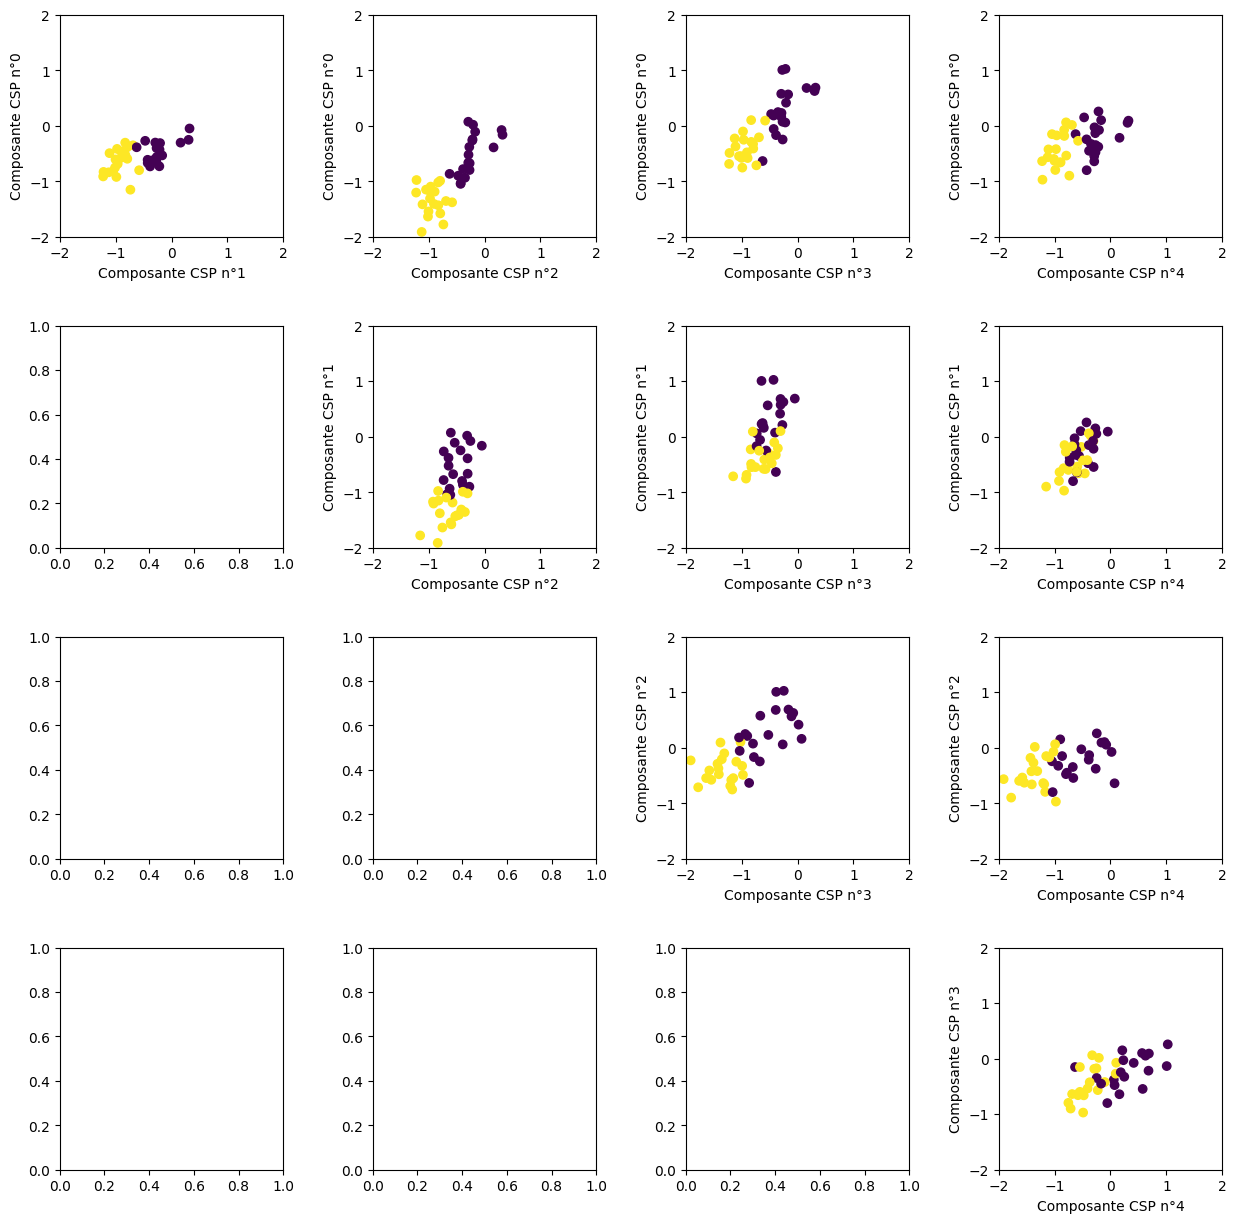

In [18]:
# # Obtenir les données transformées par la CSP
n_patient = 1
n_session = 0
csp_data = pip.transform(X_patients[n_patient][n_session])
labels = y_patients[n_patient][n_session]
plot_csp(csp_data, labels)

# 3 - 1er Cas d'utilisation de KMEANS

Ici un modèle de CSP + StandardScaler est entrainé sur une session. Puis la pipeline (CSP + Standard) + Kmeans est utilisé pour discriminer les deux clusters (mouvement OU non mouvement). A noter qu'on se fiche ici de savoir le label correspondant aux clusters.

Patient 0


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Session 0 on train - score: 0.868421052631579 on session 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Session 1 on train - score: 0.9473684210526316 on session 0
Patient 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Session 0 on train - score: 0.9736842105263158 on session 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Session 1 on train - score: 0.9736842105263158 on session 0
Patient 2


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Session 0 on train - score: 0.5714285714285714 on session 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Session 1 on train - score: 0.5476190476190477 on session 0
Patient 3


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Session 0 on train - score: 0.7894736842105263 on session 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Session 1 on train - score: 1.0 on session 0
Patient 4
  Abort, not enough sessions


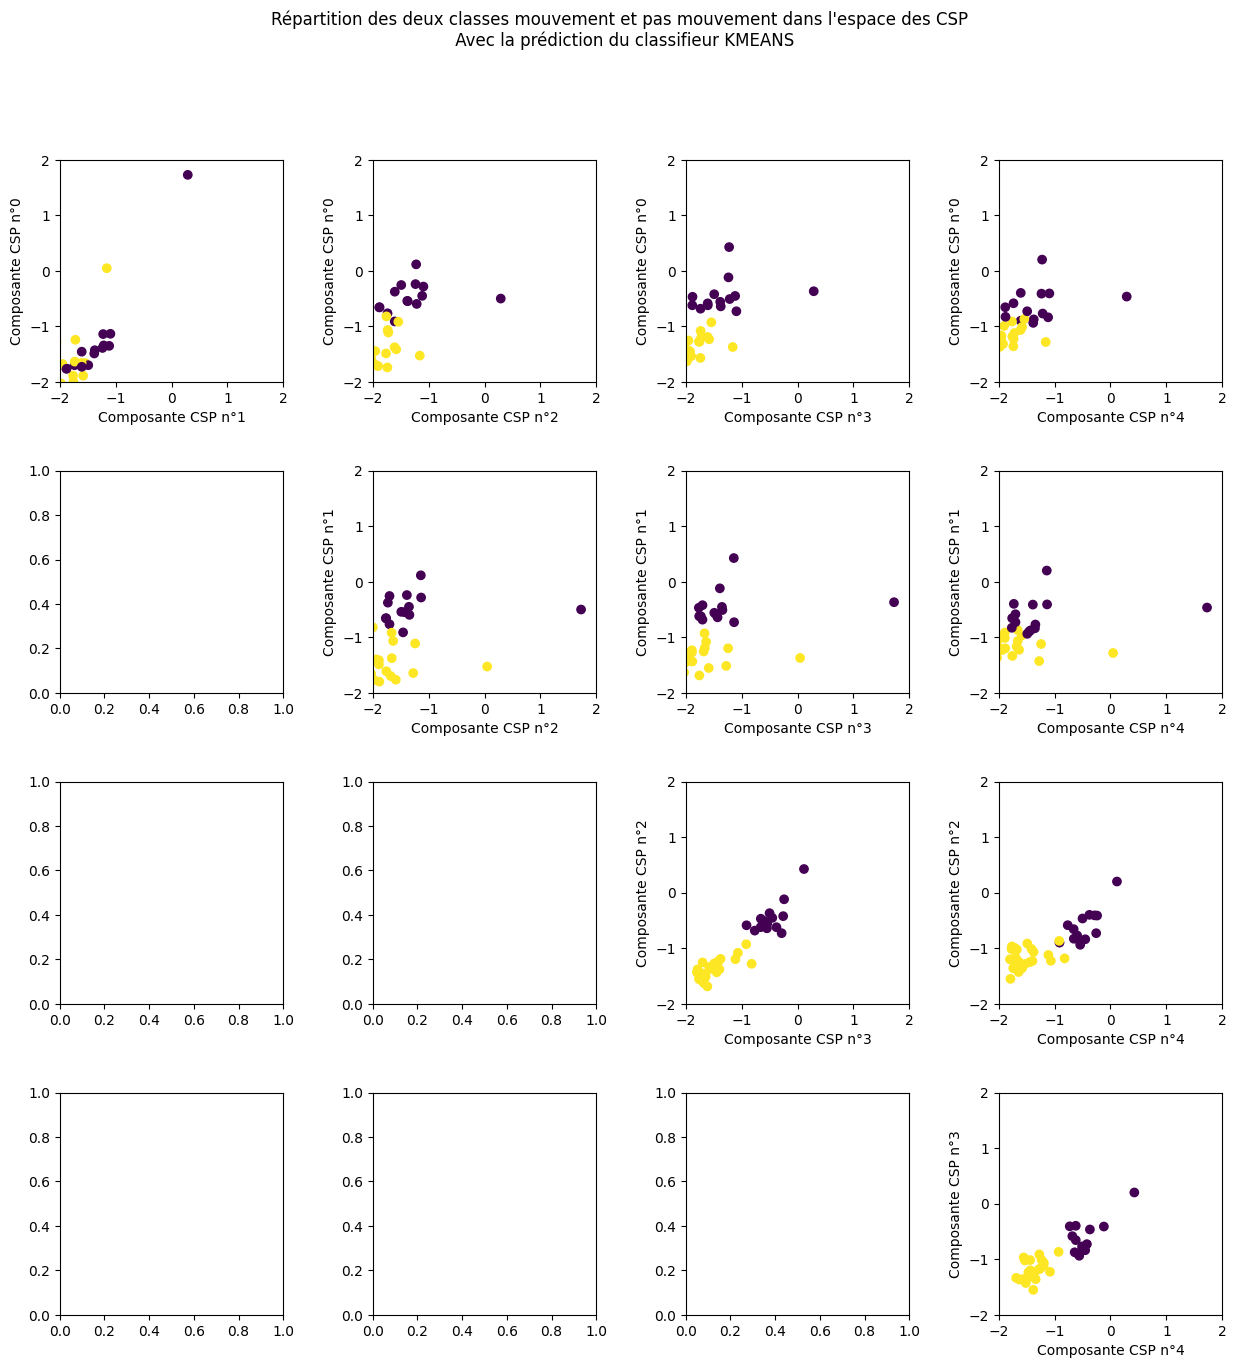

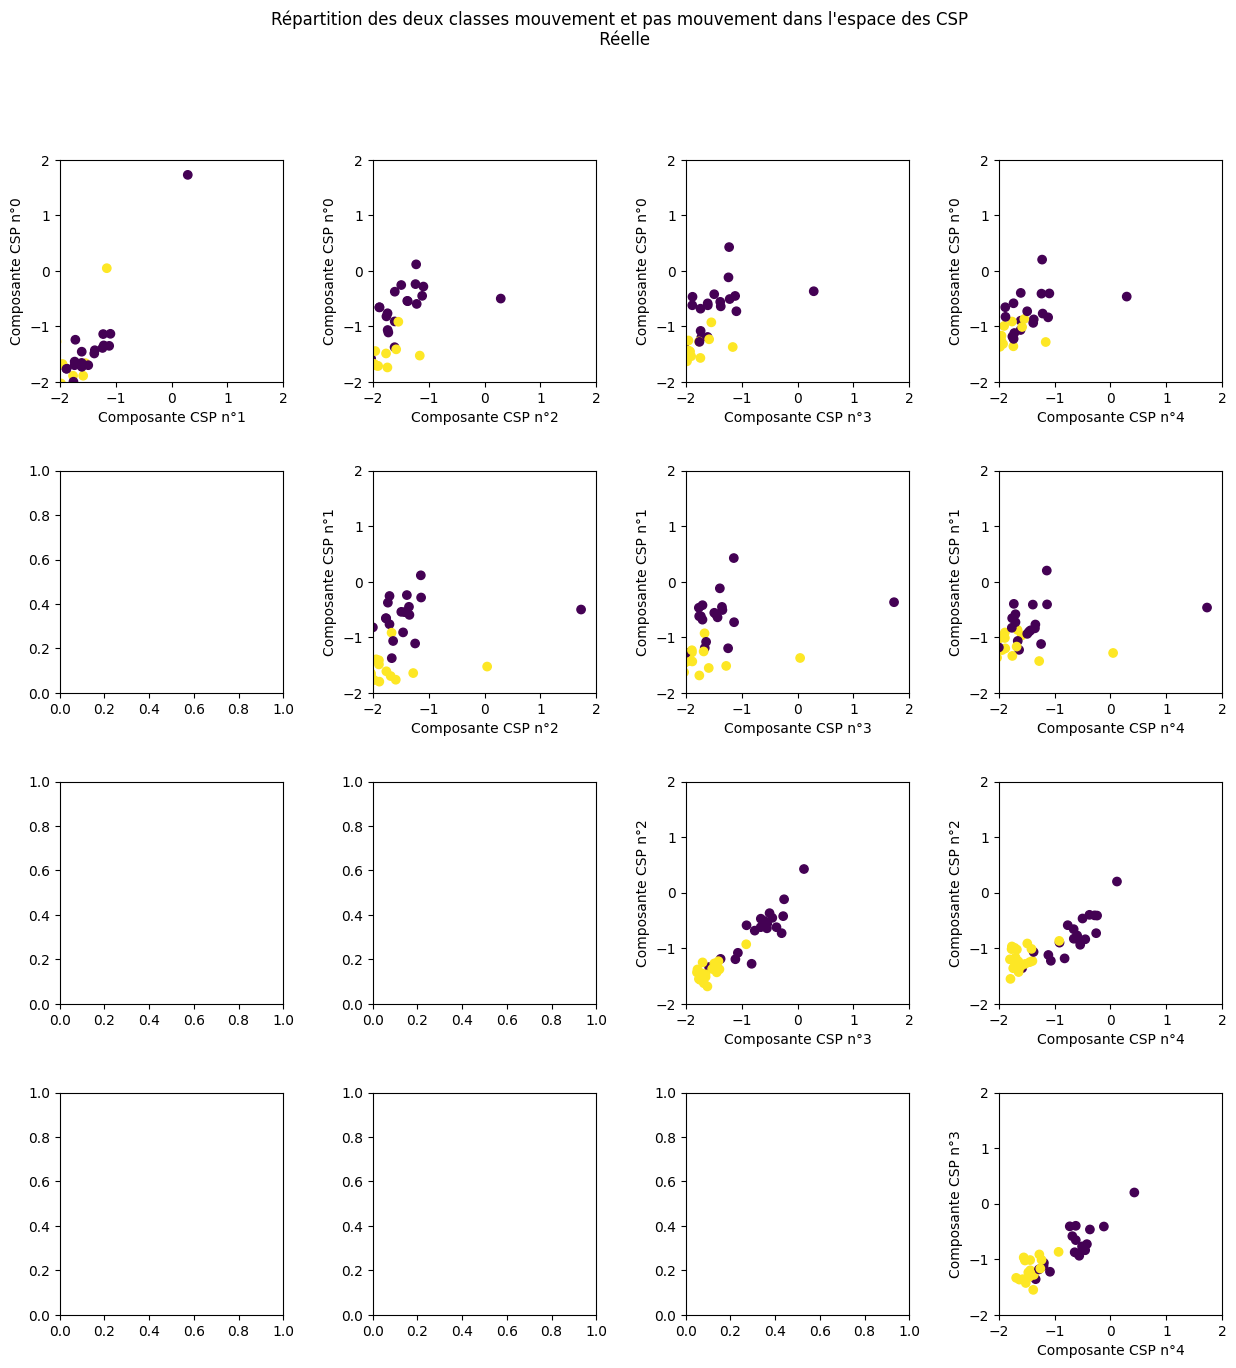

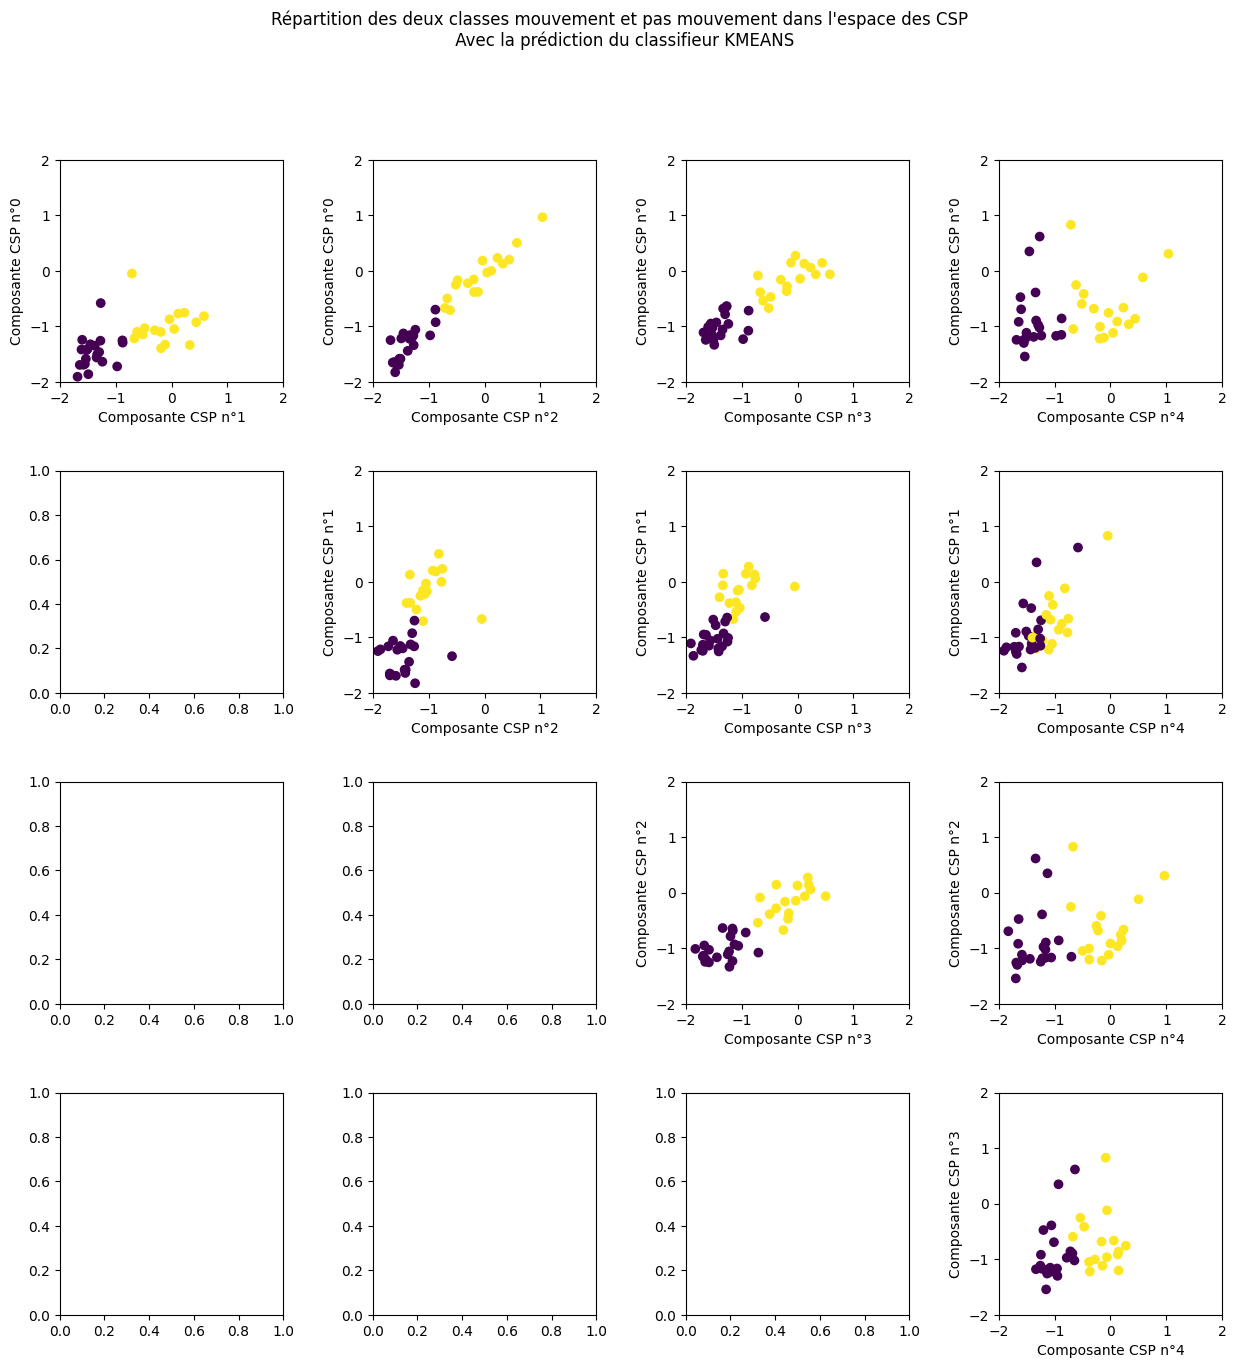

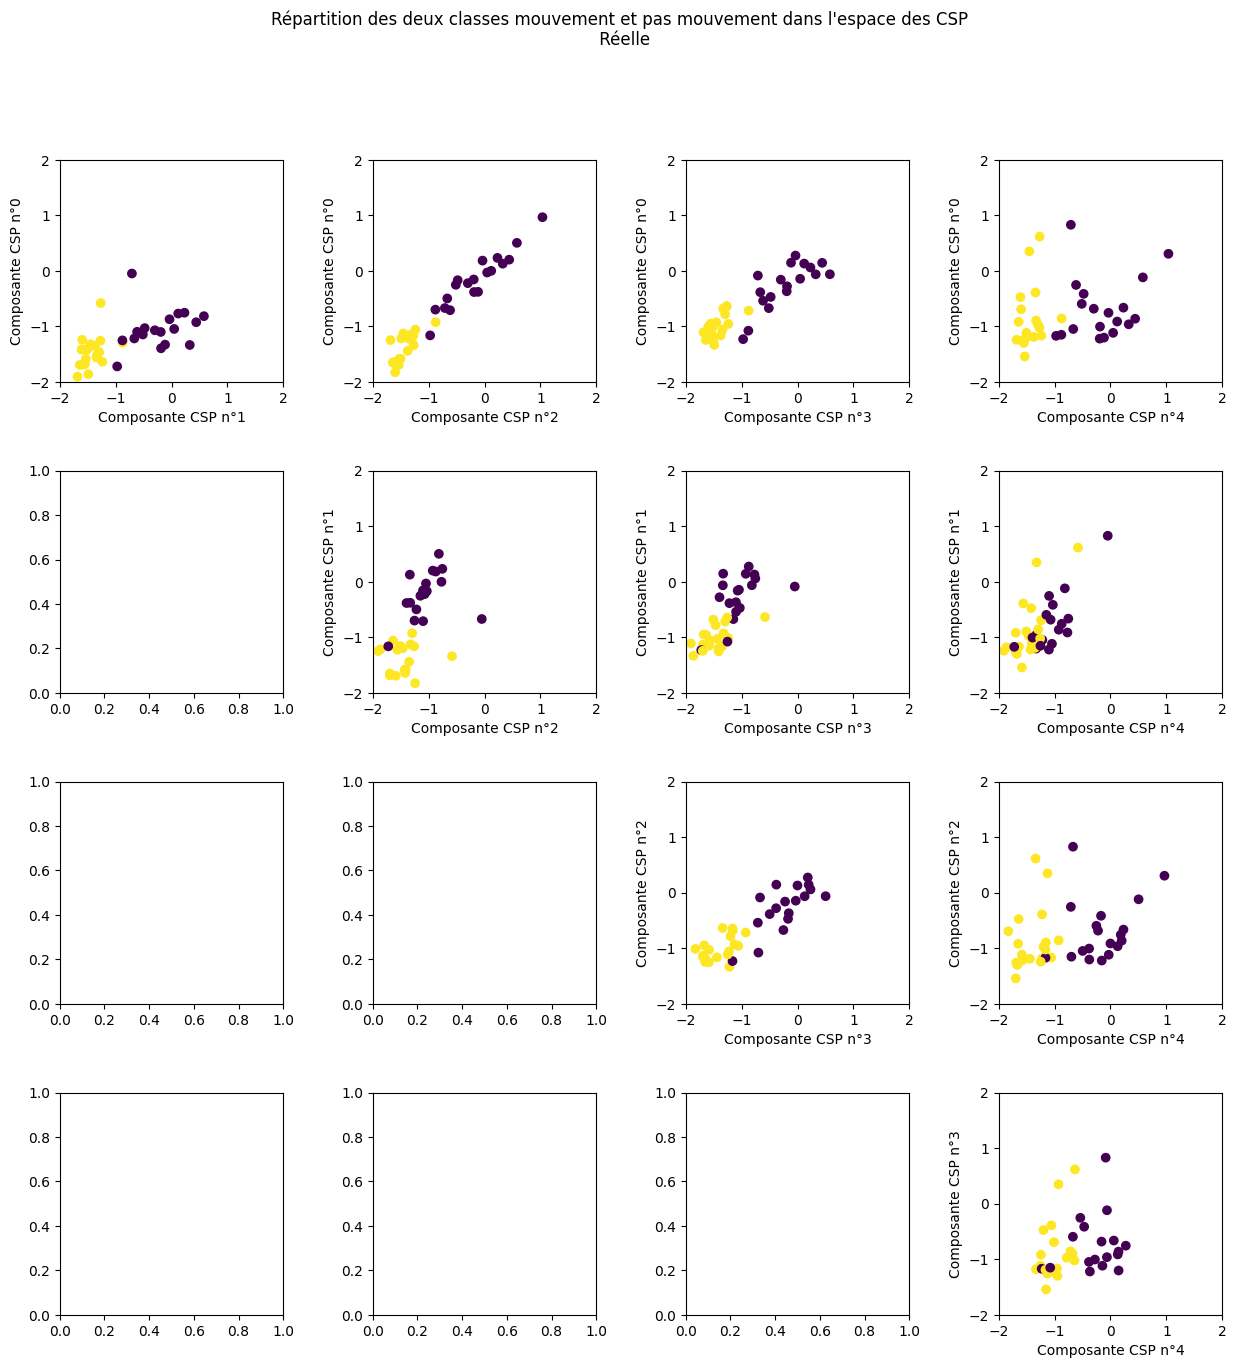

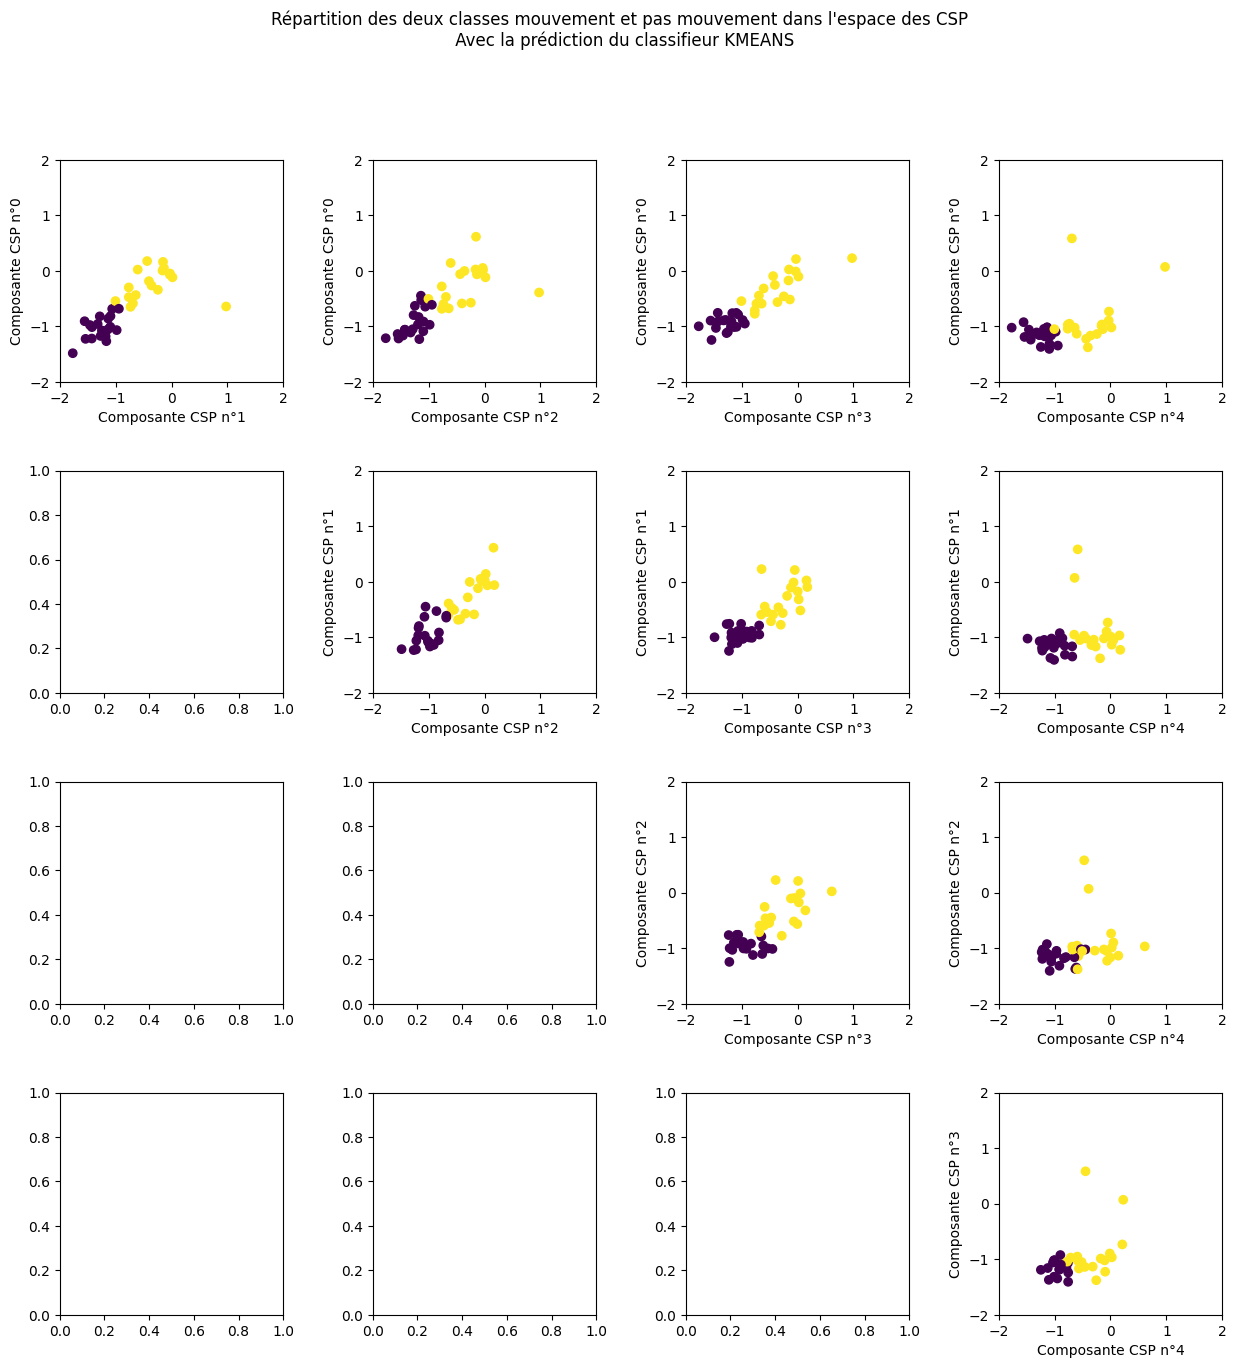

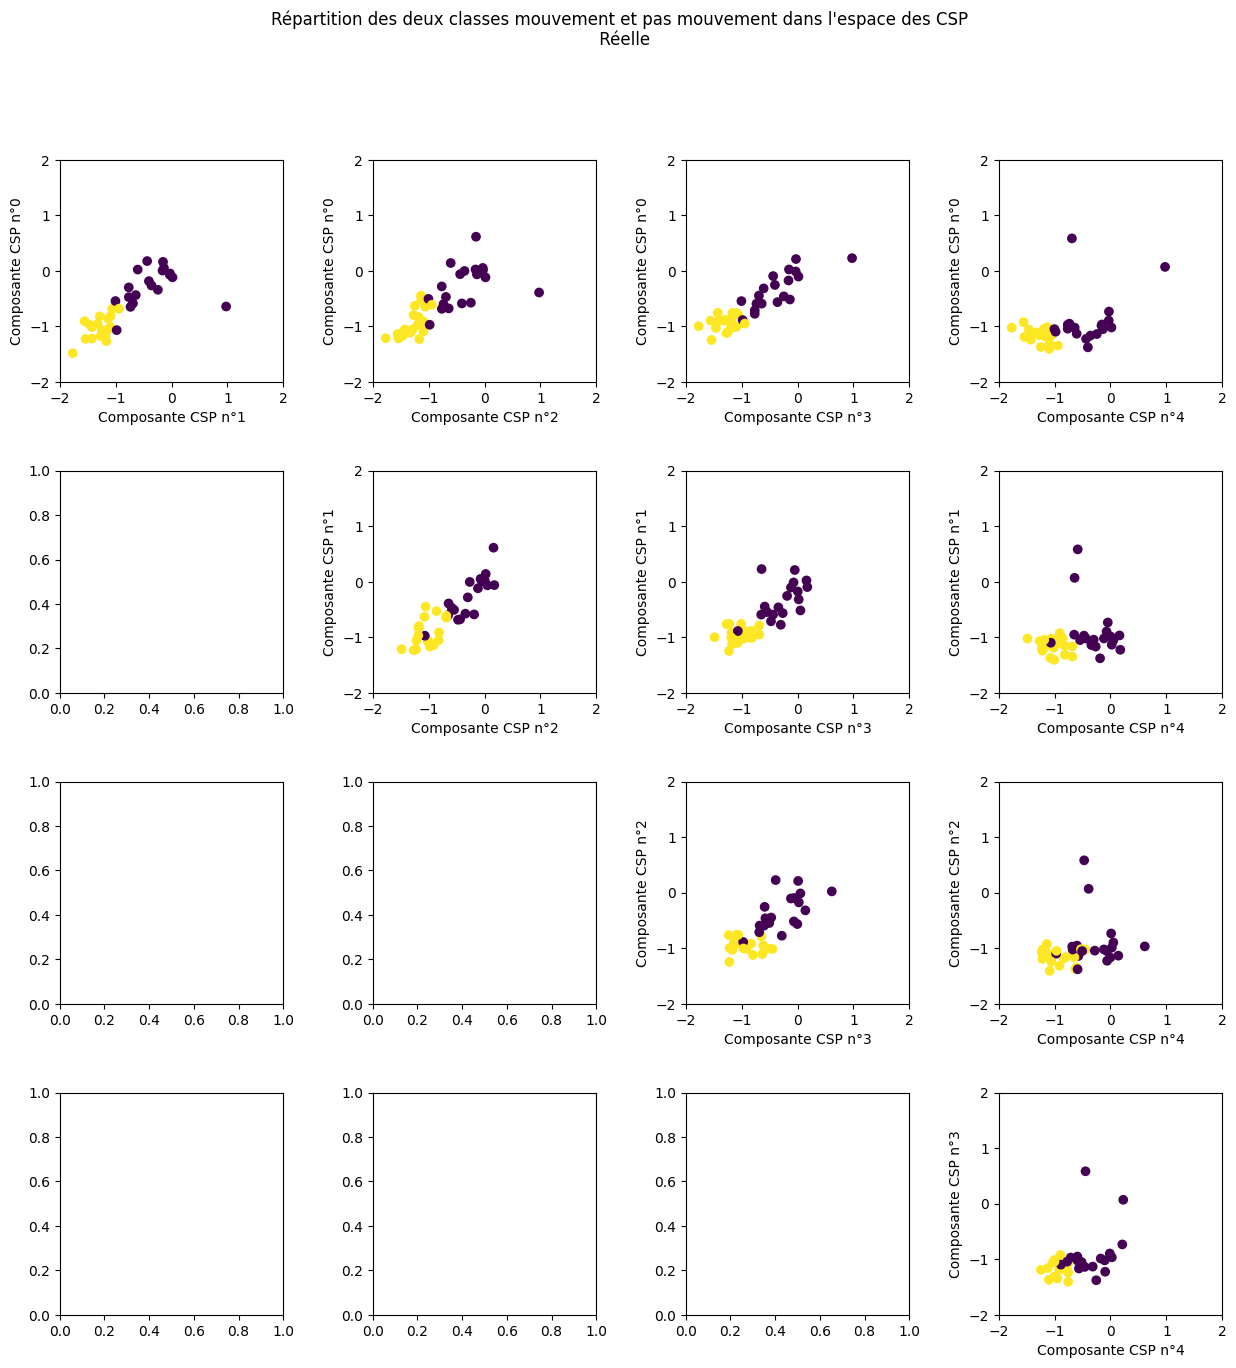

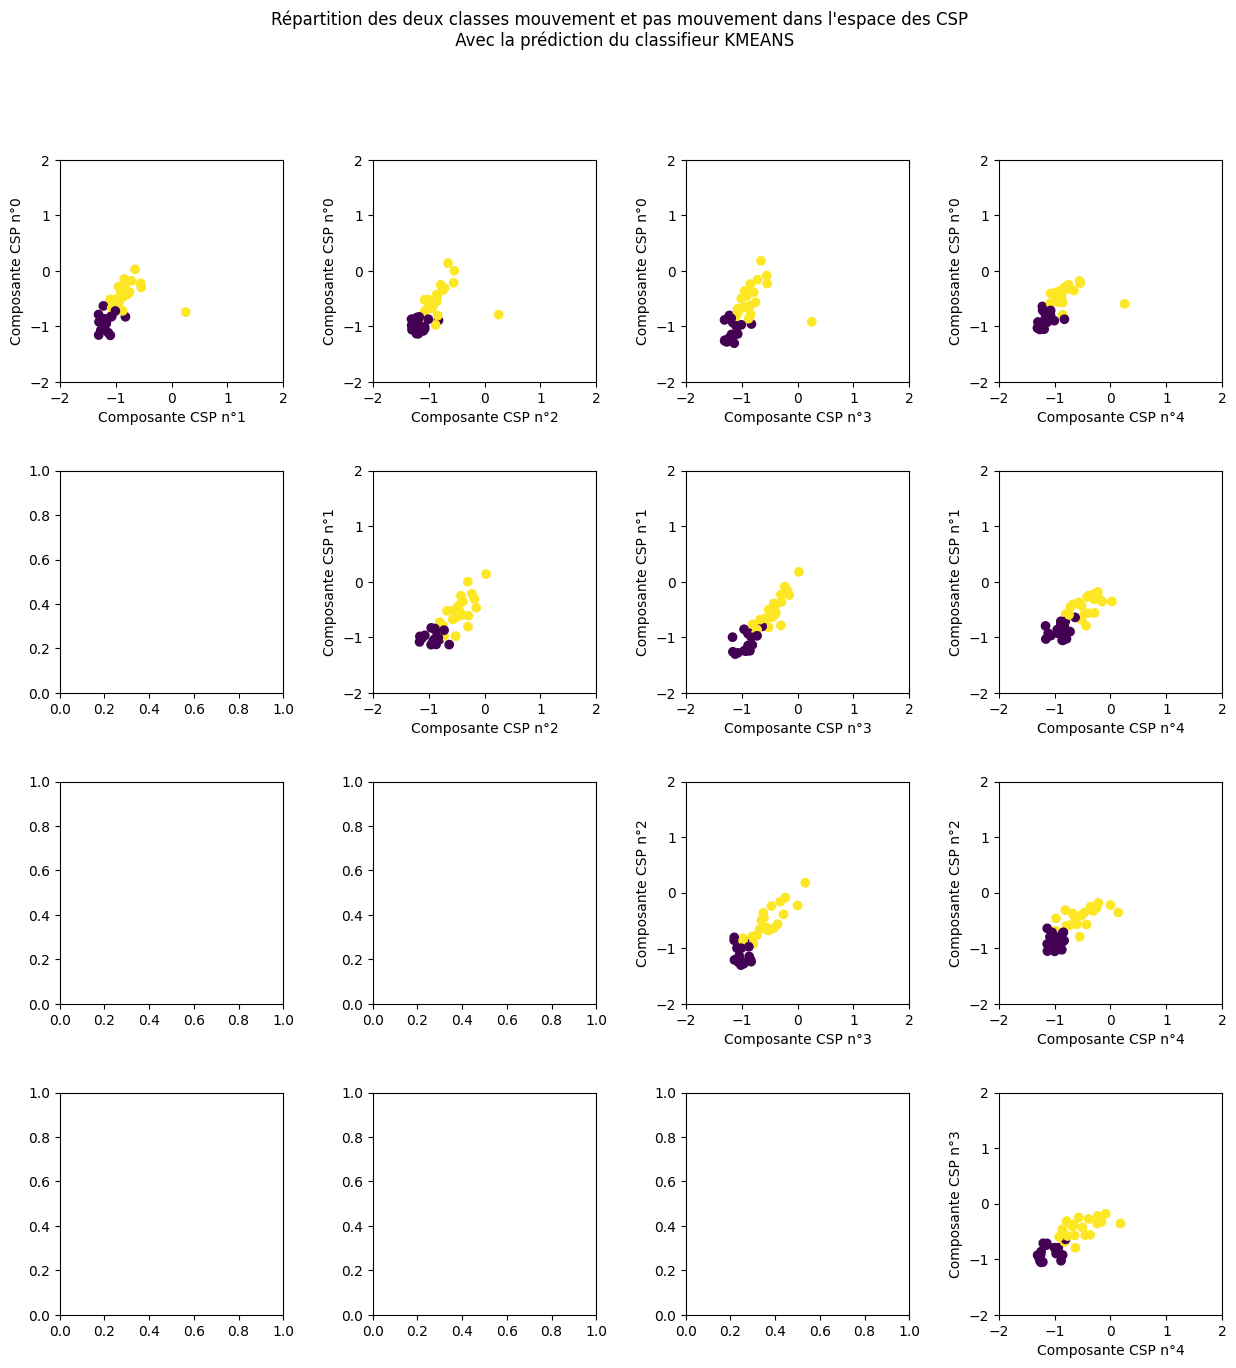

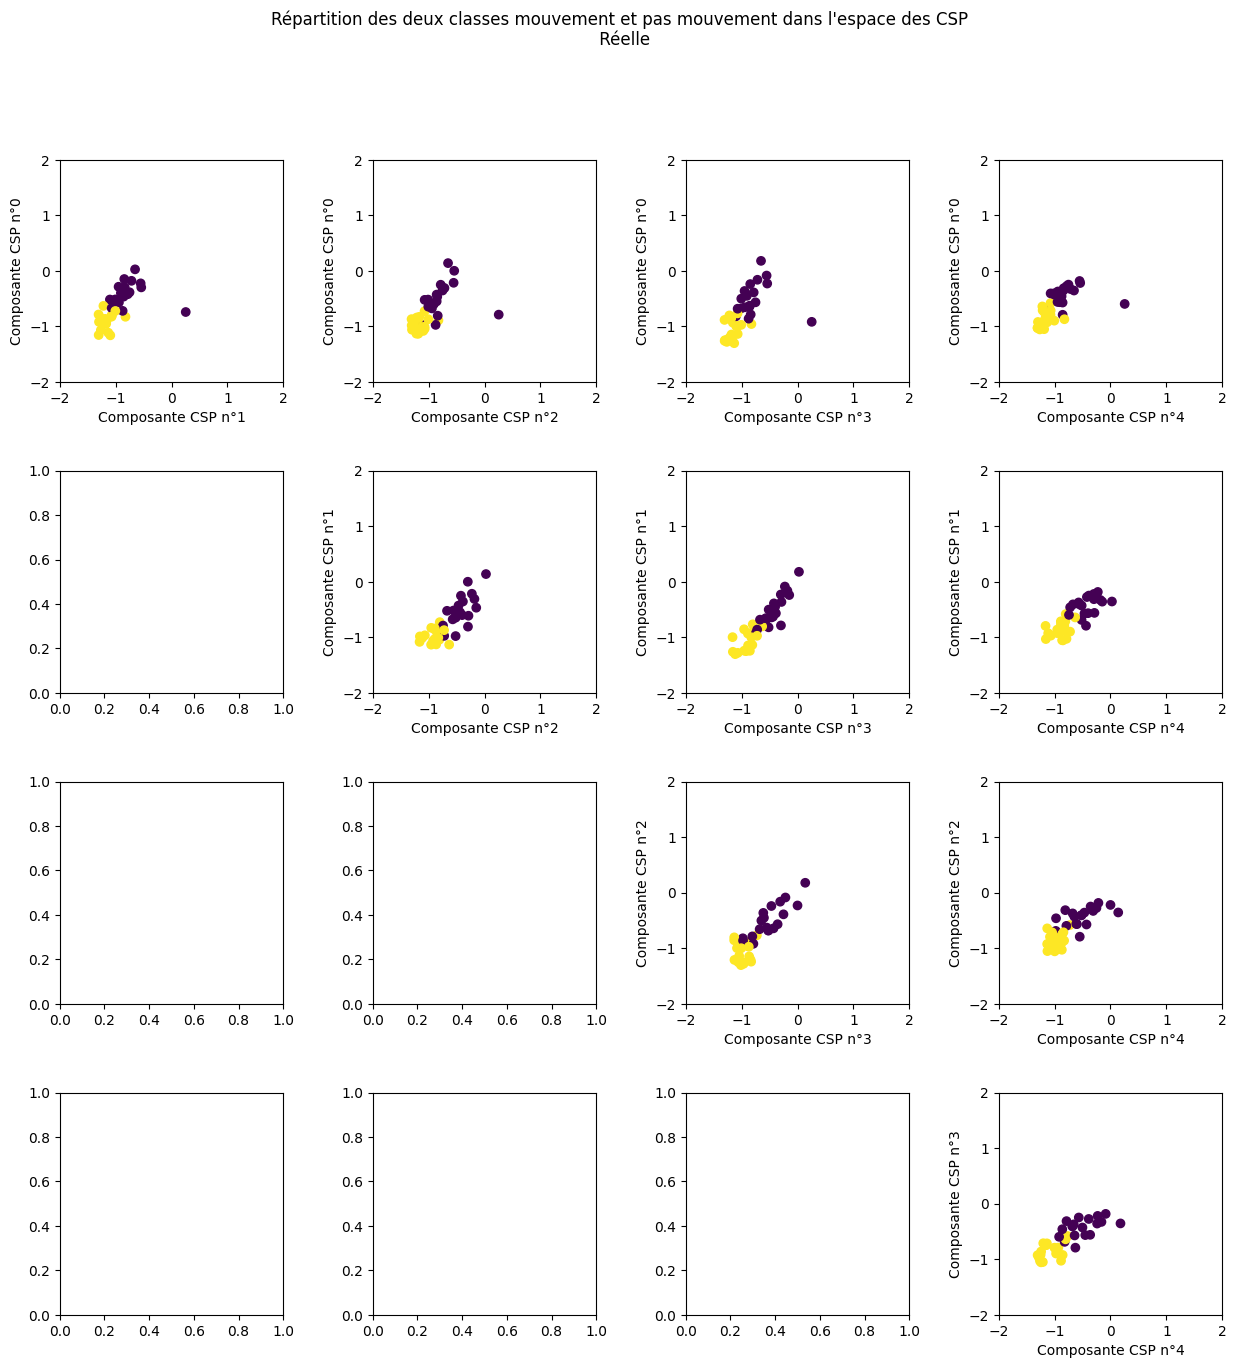

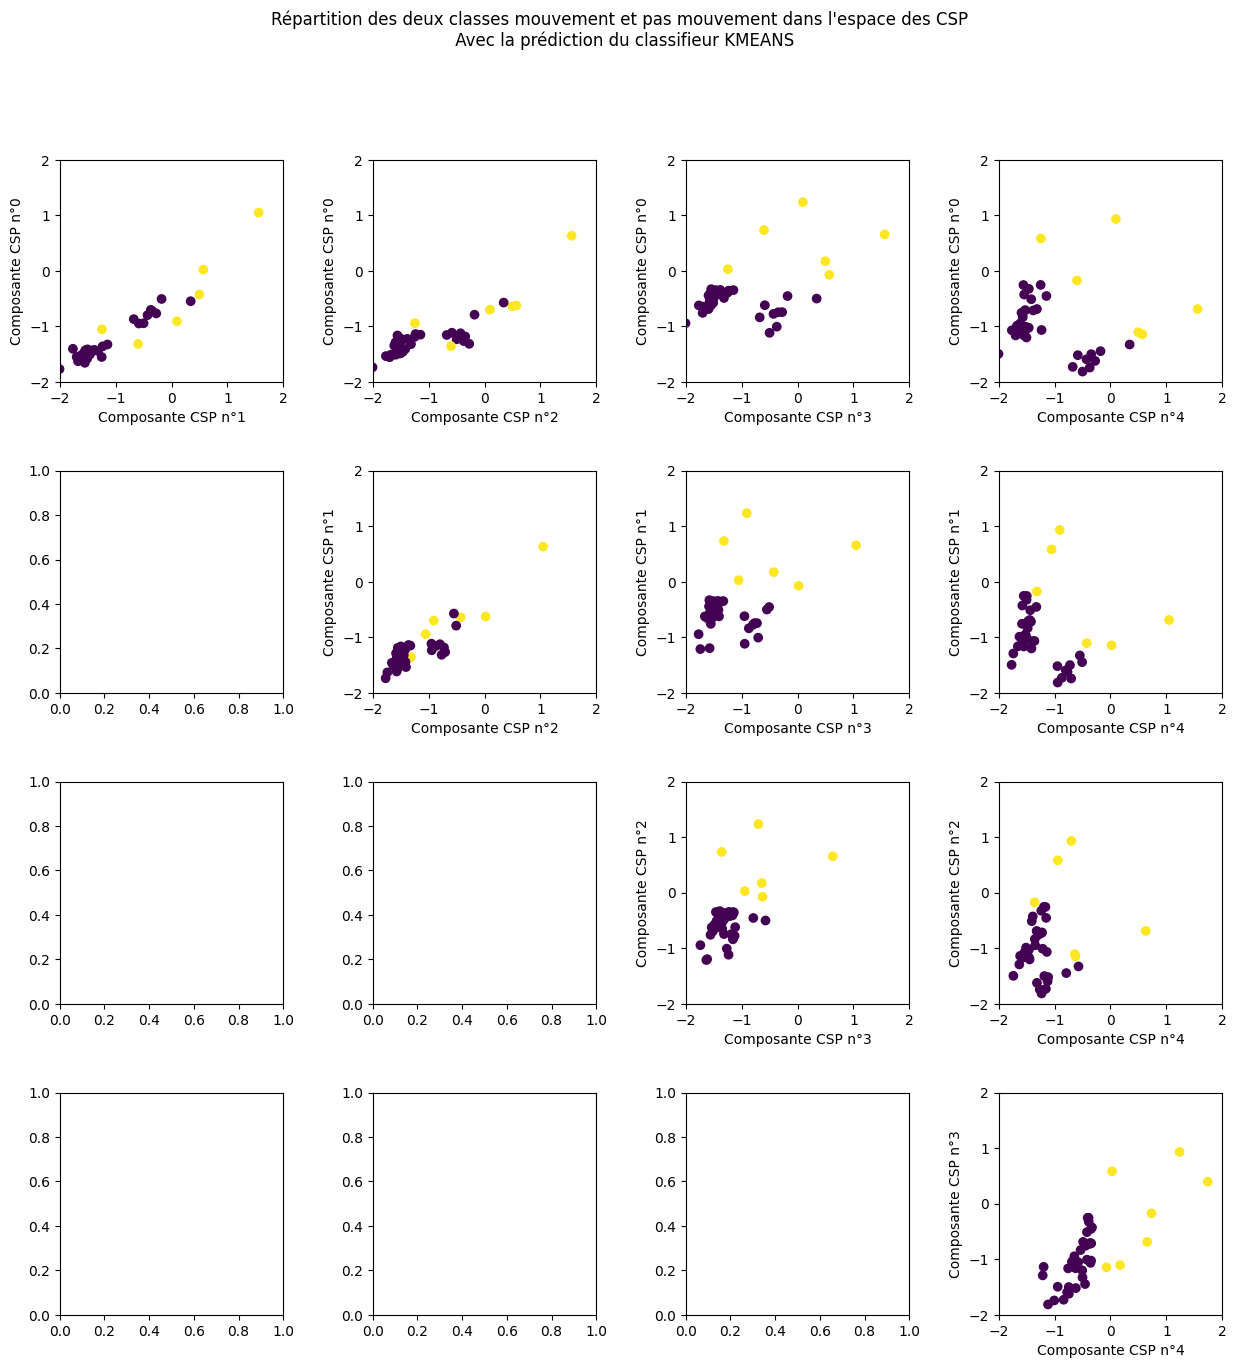

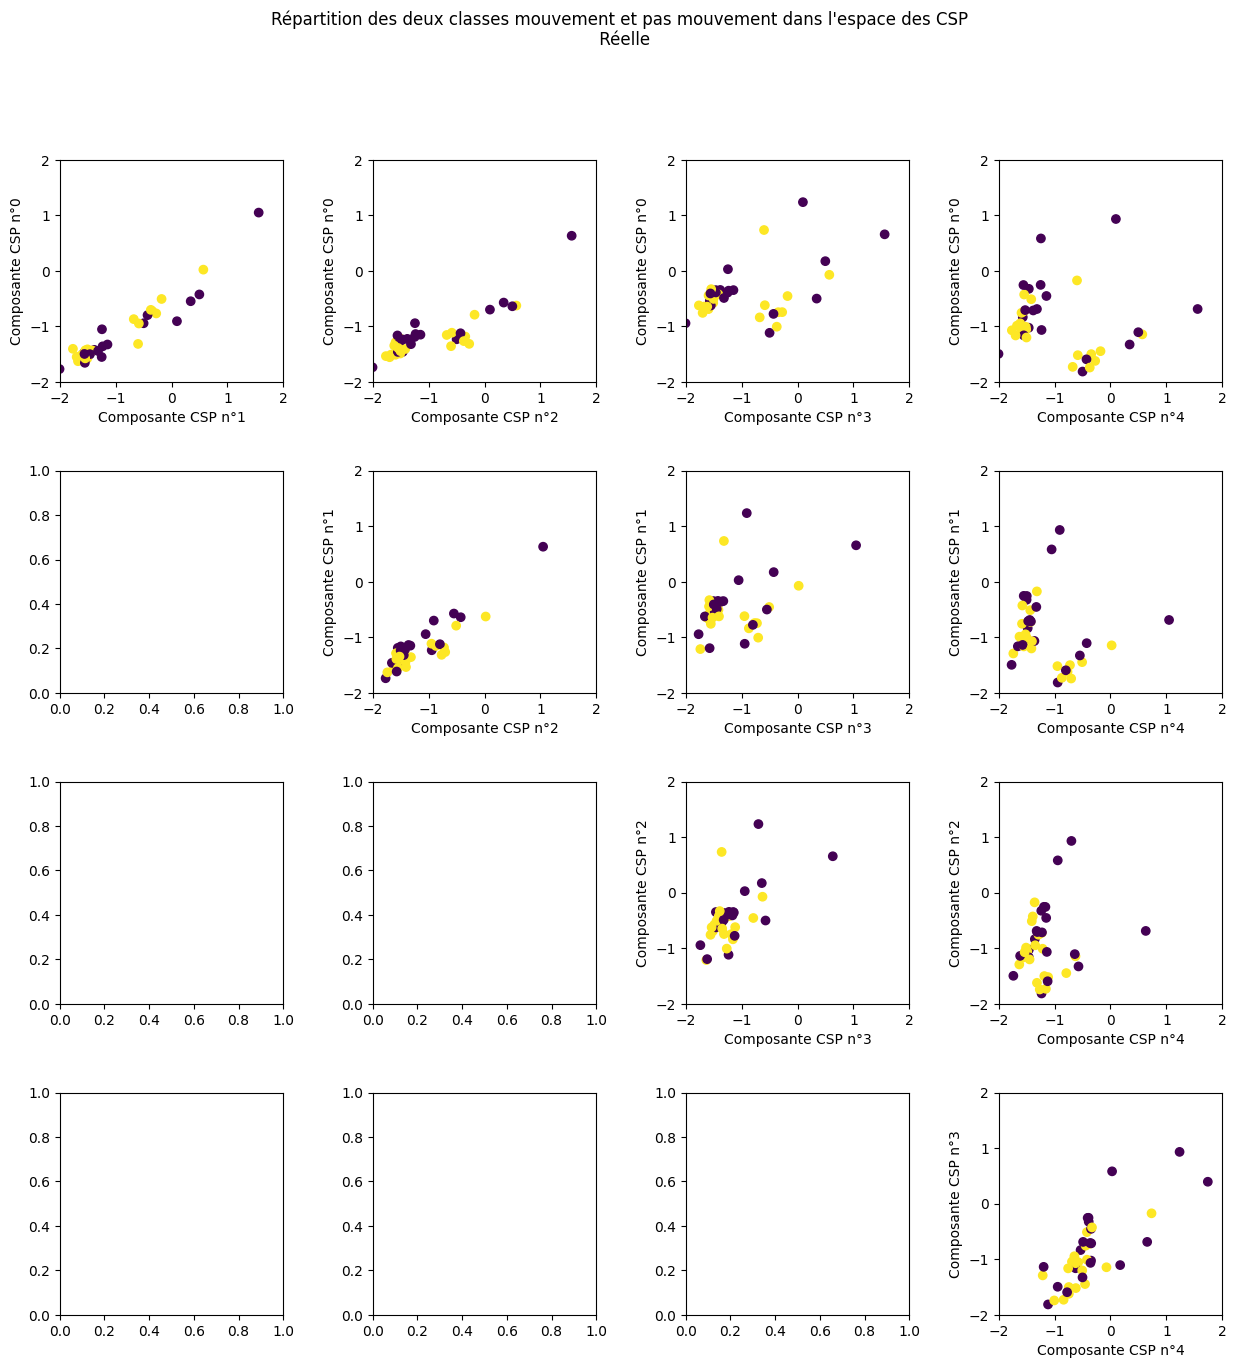

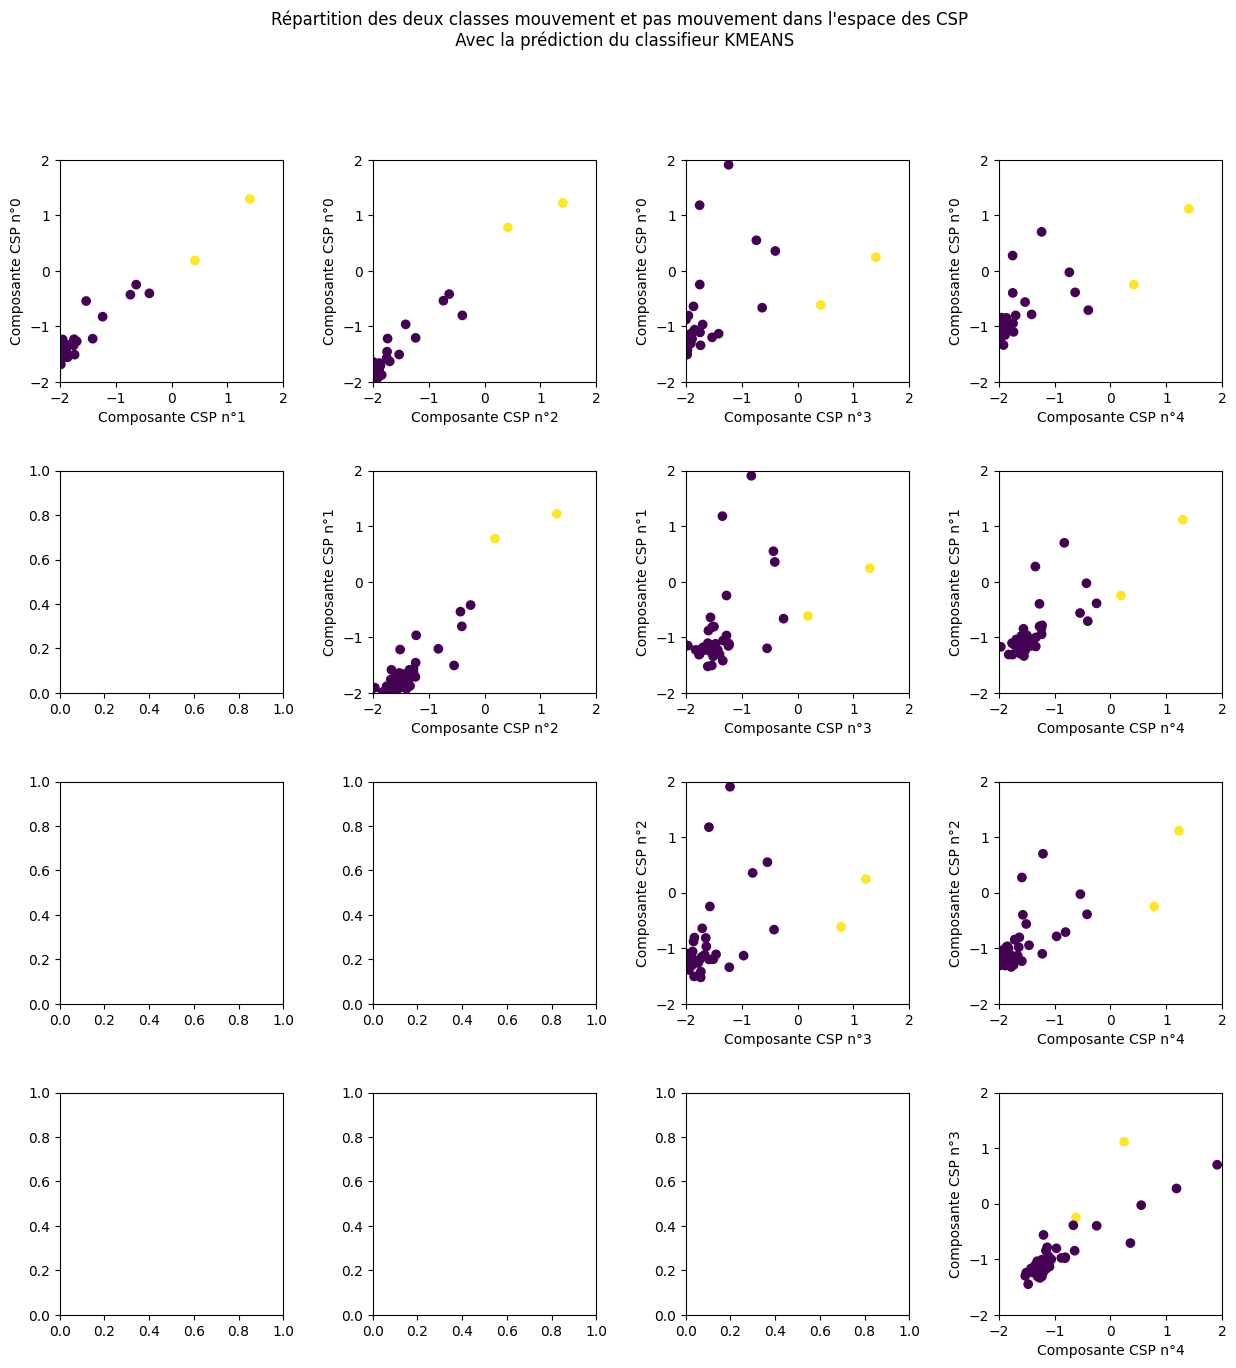

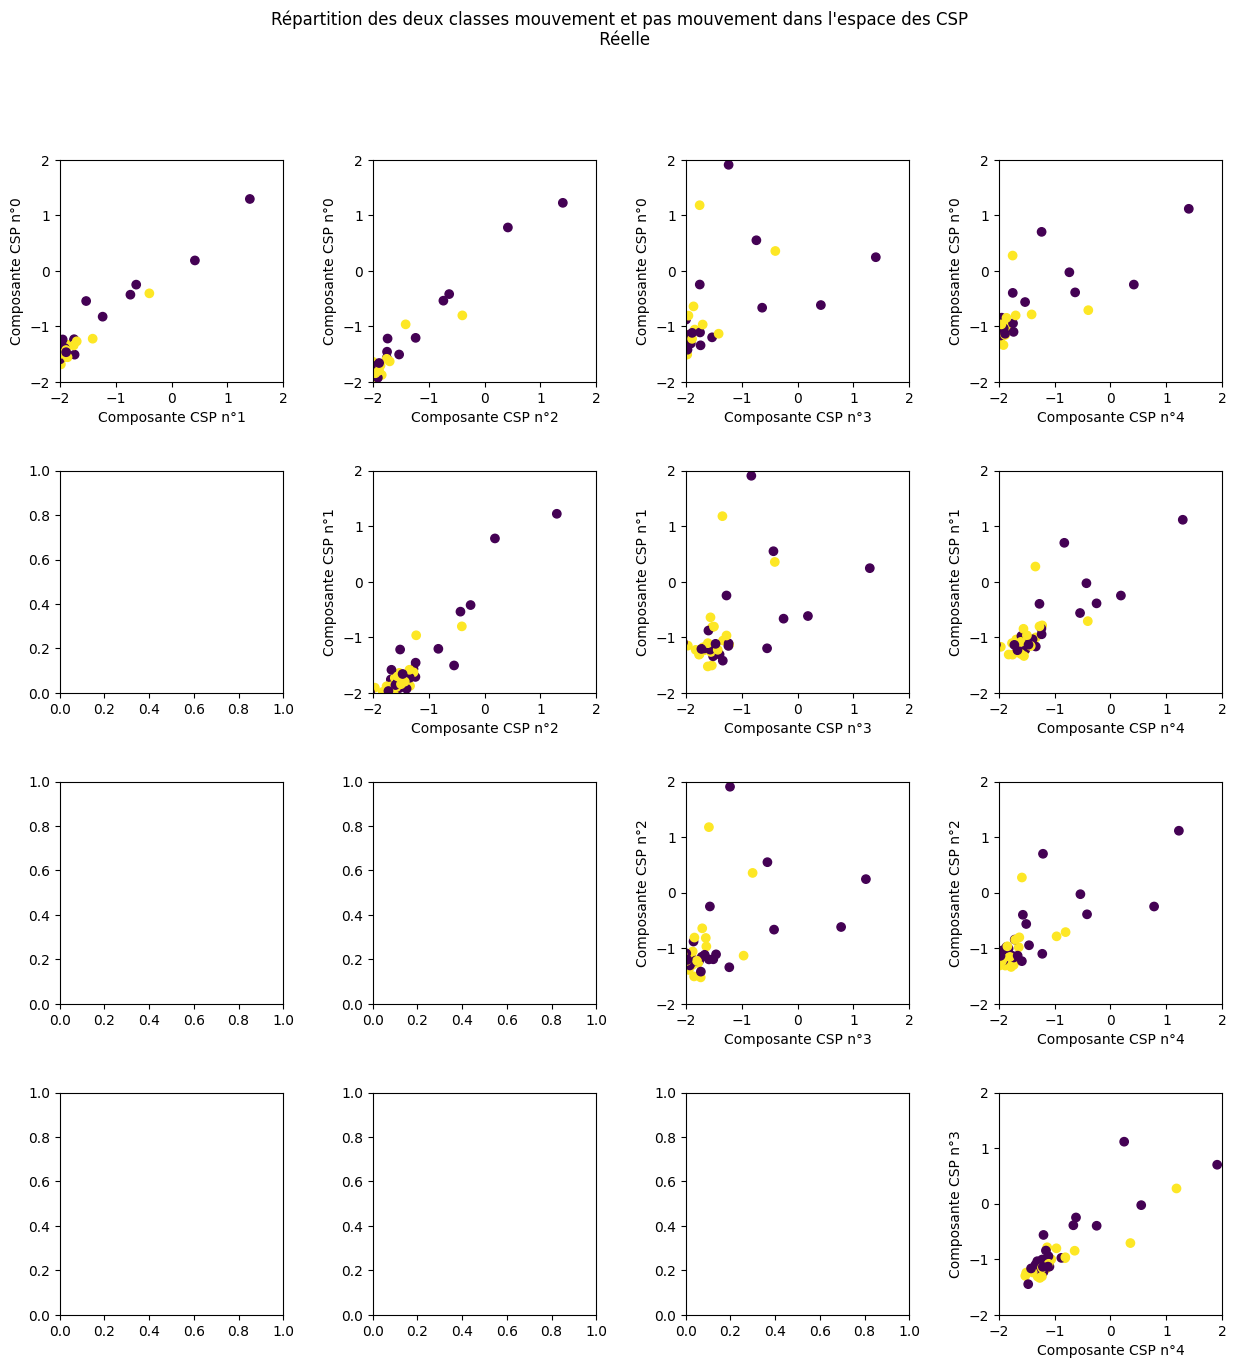

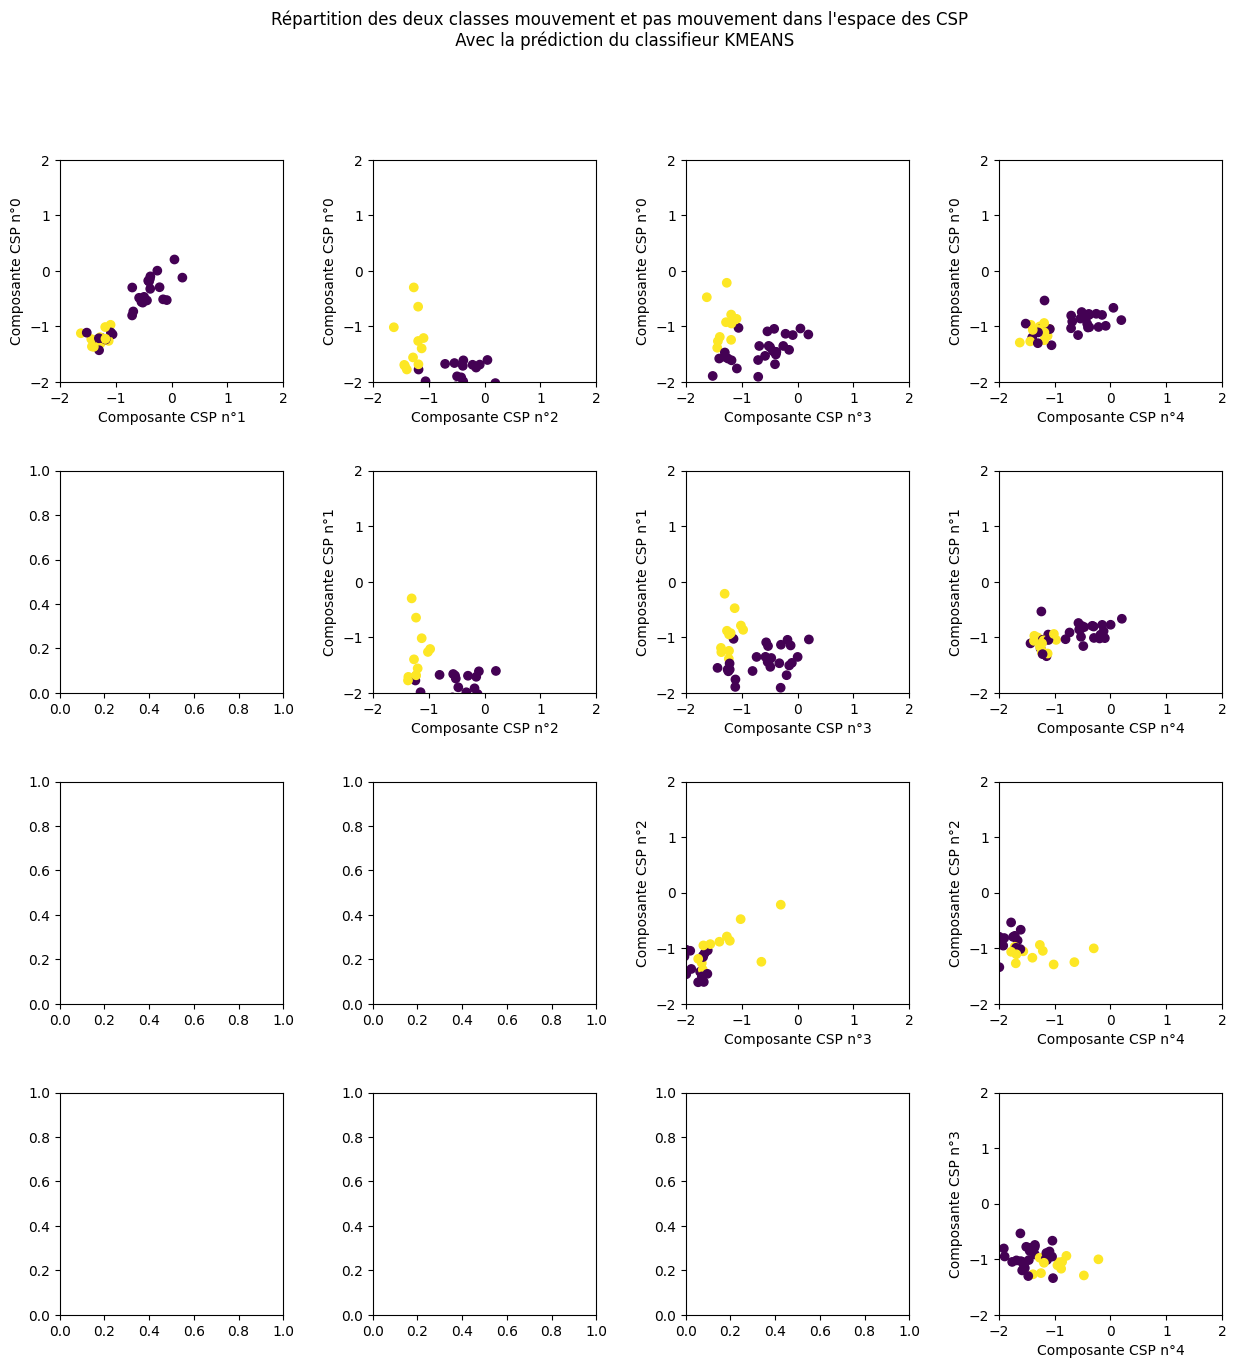

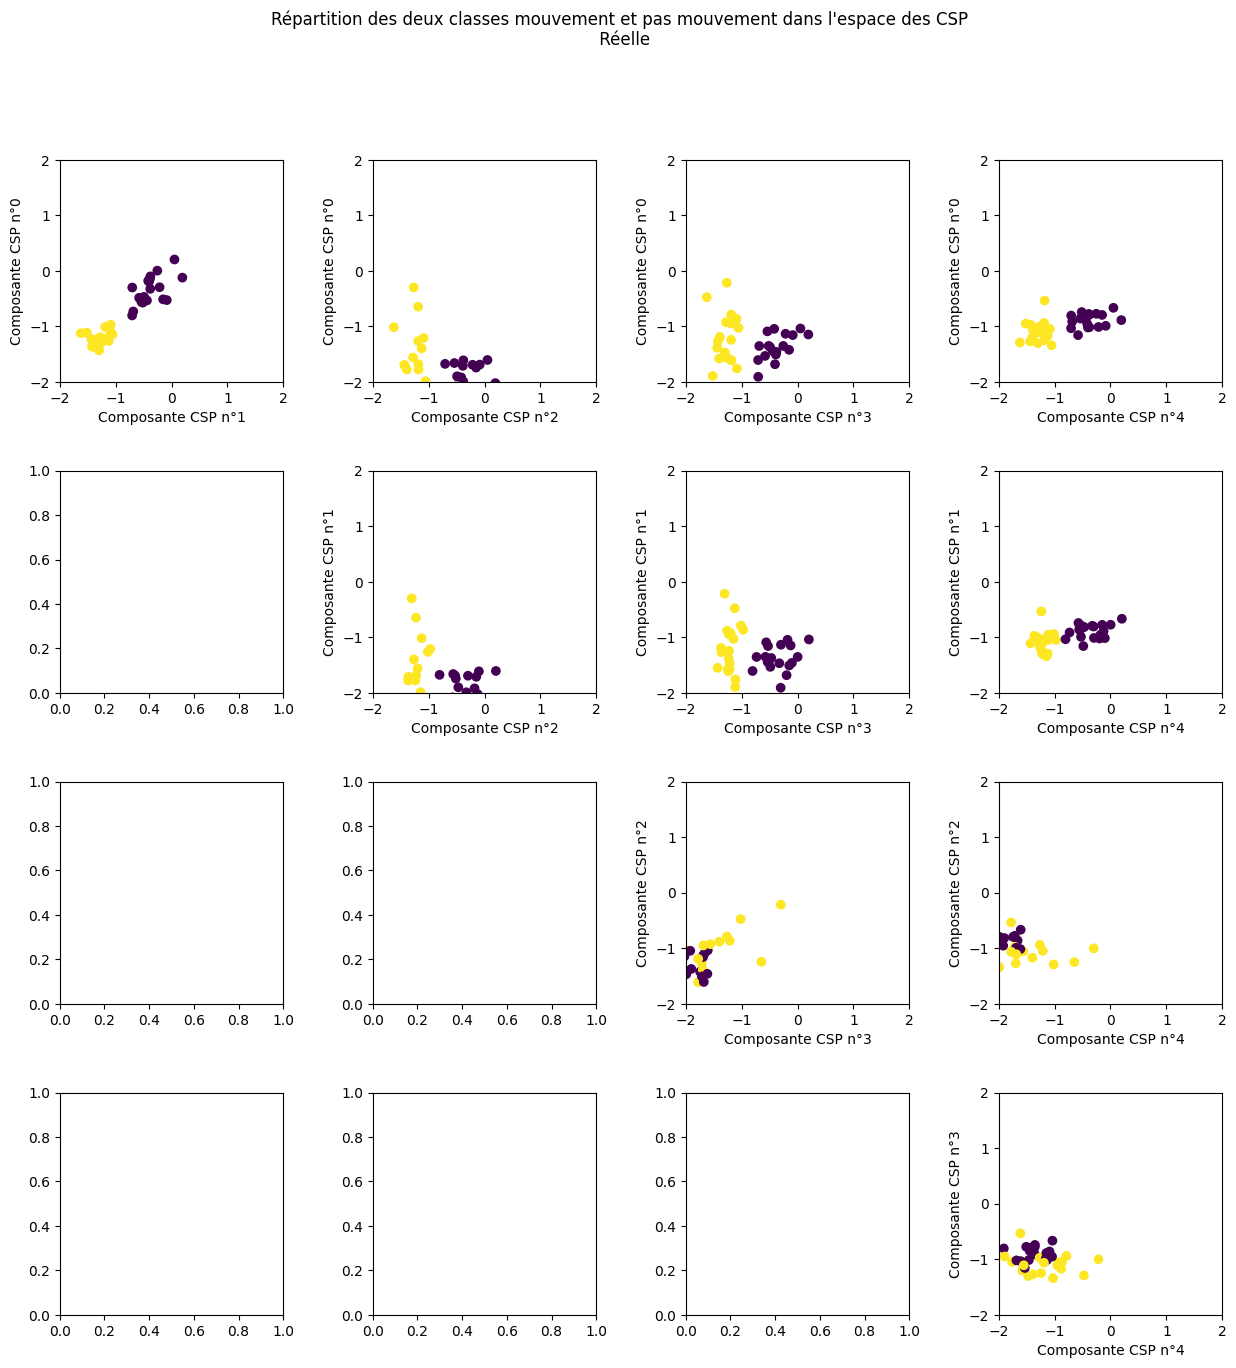

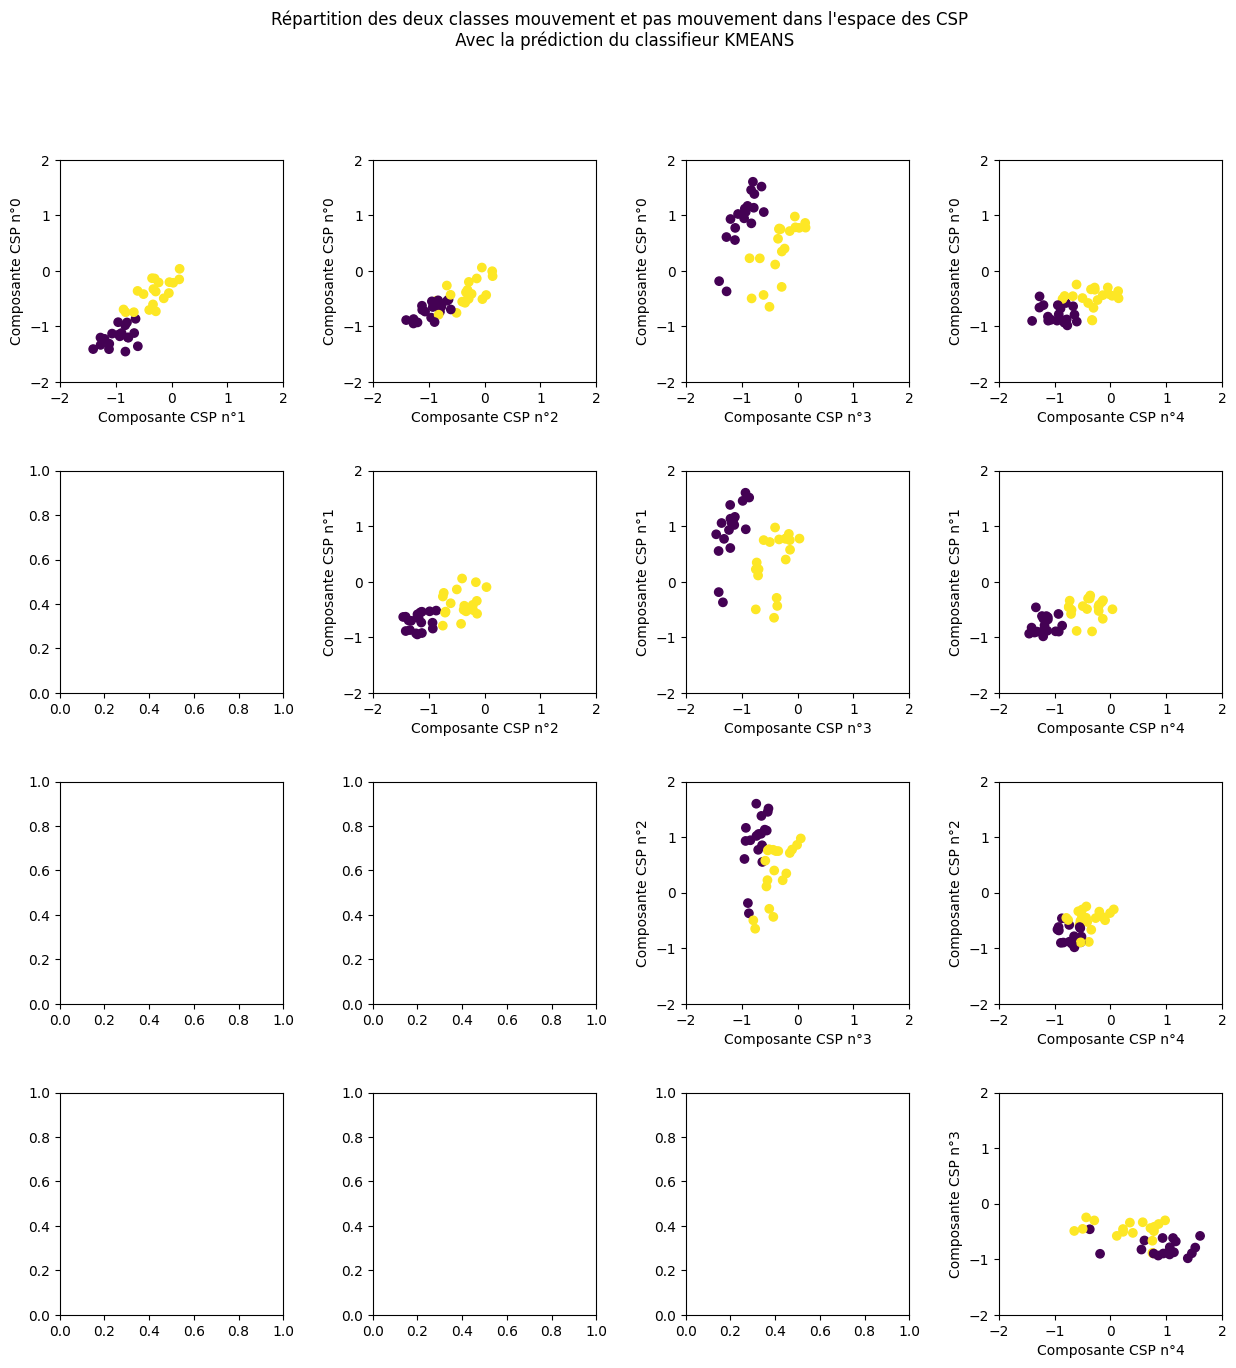

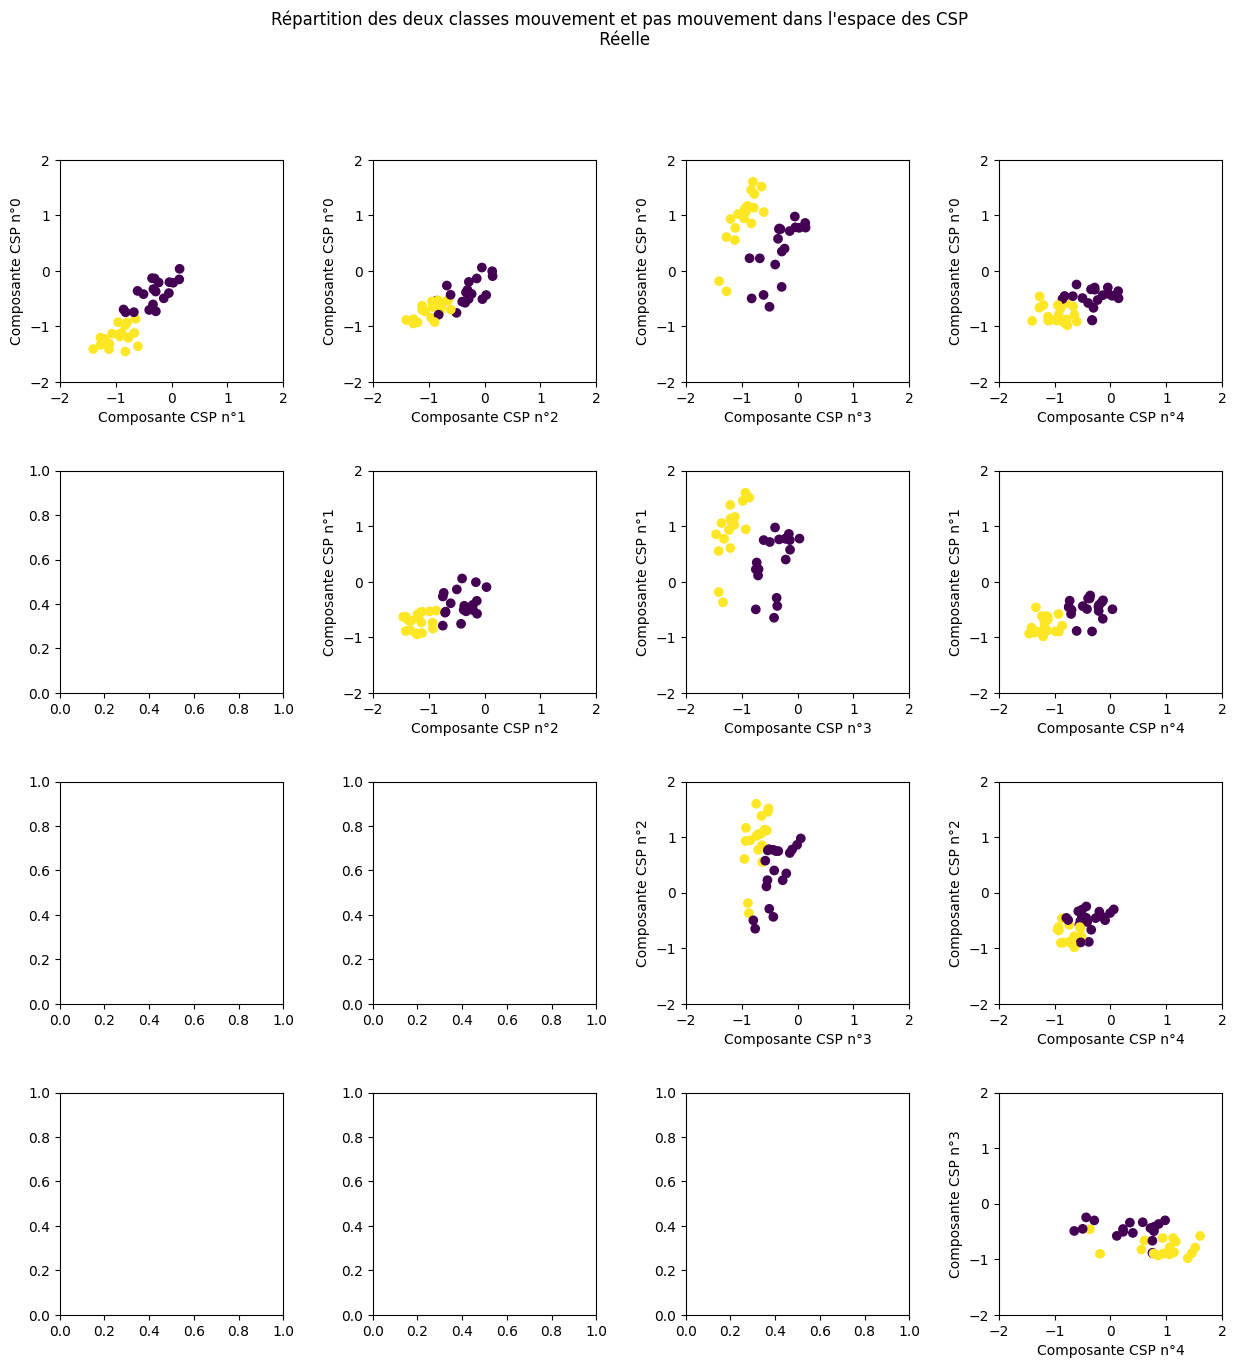

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# i_patient = 1
# i_session = 0

for i_patient in range(len(X_patients)):
    print(f'Patient {i_patient}')
    if len(X_patients[i_patient]) < 2:
        print(f"  Abort, not enough sessions")
        continue
    for i_session in range(len(X_patients[i_patient])):
        X_patient = X_patients[i_patient][i_session].copy()
        y_patient = y_patients[i_patient][i_session].copy()
        X_test = X_patients[i_patient][(1+i_session)%2].copy()
        y_test = y_patients[i_patient][(1+i_session)%2].copy()

        csp = CSP(n_components=5)
        sc  = StandardScaler()
        km = KMeans(n_clusters=2)
        svc = SVC(kernel='linear', C=.001)
        
        # rf  = RandomForestClassifier()
        # pip = Pipeline([('CSP', csp), ('sc', sc), ('SVC', svc)])
        pip = Pipeline([('CSP', csp), ('sc', sc), ('Kmeans', km)])

        pip.fit(X_patient, y_patient)
        # score = pip.score(X_test, y_test)

       
        y_pred = pip.predict(X_test)
        score = accuracy_score(y_test,y_pred)

        csp_data = pip.named_steps["CSP"].transform(X_test)
        plot_csp(csp_data, y_pred)
        plt.suptitle("Répartition des deux classes mouvement et pas mouvement dans l'espace des CSP \n Avec la prédiction du classifieur KMEANS")
        plot_csp(csp_data, y_test)
        plt.suptitle("Répartition des deux classes mouvement et pas mouvement dans l'espace des CSP \n Réelle")
        
        if score < 0.5:
            score = 1 - score 

        print(f'  Session {i_session} on train - score: {score} on session {(1+i_session)%2}')

In [27]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from mne.decoding import CSP

N_COMPONENTS = 5
N_SPLITS = 5


class VotingClassifier():
    def __init__(self) -> None:
        self.clfs = []
        self.y_true = None

    def fit_clf_session(self, X, y):
        """
        Fits the inner classifiers on sessions data. 
        NB: one session is a list of epochs.

        X: list of epochs
        y: list of labels
        """
        csp = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)
        sc = StandardScaler()
        km = KMeans(n_clusters=2)
        clf = Pipeline([('CSP', csp), ('SC', sc), ('KMEANS', km)])

        clf.fit(X, y)
        return clf
        
    def fit(self, X, y):
        """
        Fits the outer classifier on sessions data.

        X: list of sessions, each session is a list of epochs
        y: list of sessions, each session is a list of labels
        """
        clfs = []
        for session in range(len(X)):
            clfs.append(self.fit_clf_session(X[session], 
                                             y[session]))
        self.clfs = clfs

    def predict(self, X, return_probas=False):
        """
        Predicts labels of data.

        X: list of epochs
        """
        X = [epoch for session in X for epoch in session]
        X = np.array(X)

        preds = np.zeros(X.shape[0])
        for i in range(len(self.clfs)):
            clf = self.clfs[i]
            y_pred = clf.predict(X)
            preds += y_pred


            # # Affichage des résultats pour le classifieur n°i
            # plt.figure(figsize=(5, 5))
            # plt.scatter(np.arange(len(y_pred)), y_pred, c=self.y_true, cmap='viridis')
            # plt.title(f'Result for classifier n°{i}')
            # plt.show()


        preds = preds / len(self.clfs)

        if return_probas:
            return (preds > 0.5).astype(int), preds
        else:
            return (preds > 0.5).astype(int)
    
    def score(self, X, y, return_probas=False):
        """
        Scores the classifier.
        
        X: list of sessions, each session is a list of epochs
        y: list of sessions, each session is a list of labels
        """
        y_flat = np.array([label for session in y for label in session])
        y_pred = self.predict(X, return_probas=False)
        return balanced_accuracy_score(y_flat, y_pred)


def cv_test_alt(data_X, data_y, verbose=False, display=False):
    """
    data_X: list of sessions, each session is a list of epochs
    data_y: list of sessions, each session is a list of labels
    """
    # Define cross validation fold
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scores = []

    for train_idx, test_idx in cv.split(data_X):
        # Split data
        X_train = [data_X[i] for i in train_idx]
        y_train = [data_y[i] for i in train_idx]
        X_test  = [data_X[i] for i in test_idx]
        y_test  = [data_y[i] for i in test_idx]

        # Define pipelines + voting classifier
        pipeline = VotingClassifier()

        # Fit
        pipeline.fit(X_train, y_train)

        # Score
        score = pipeline.score(X_test, y_test)
        scores.append(score)

        if display:

            y_true = np.array([label for session in y_test for label in session])
            pipeline.y_true = y_true
            y_pred, probas = pipeline.predict(X_test, return_probas=True)

            plt.figure(figsize=(5, 5))
            plt.scatter(np.arange(len(probas)), probas, c=y_true, cmap='viridis')
            plt.show()

        if verbose:
            print(f'Balanced accuracy: {score}')
    
    if verbose:
        print(f'Mean balanced accuracy: {np.mean(scores)}')
    
    return scores

c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

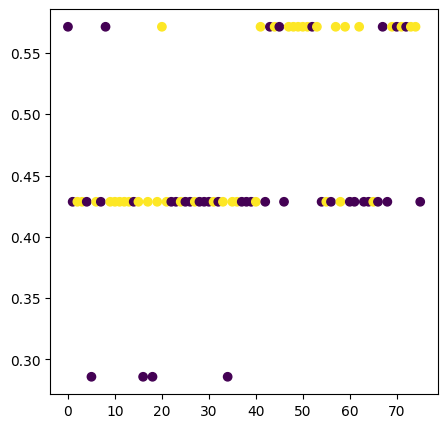

Balanced accuracy: 0.6052631578947368


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

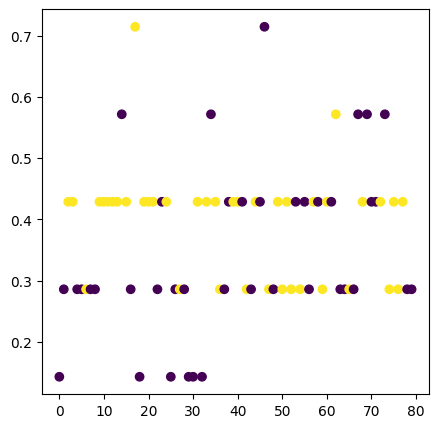

Balanced accuracy: 0.45


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

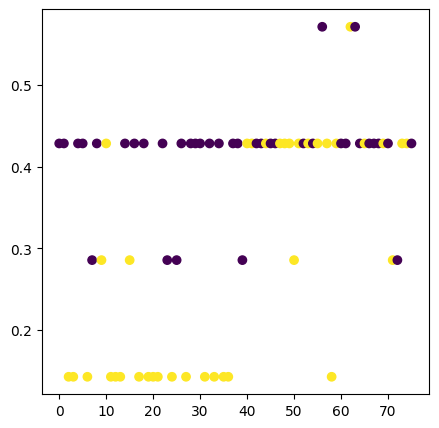

Balanced accuracy: 0.48684210526315785


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

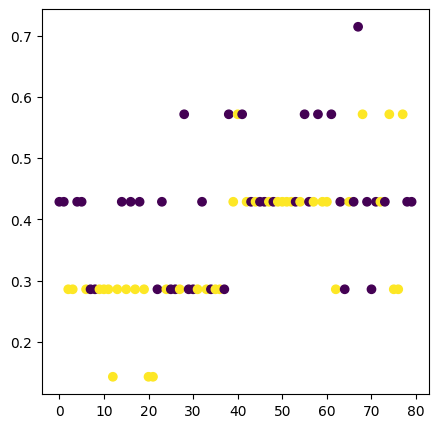

Balanced accuracy: 0.46249999999999997


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

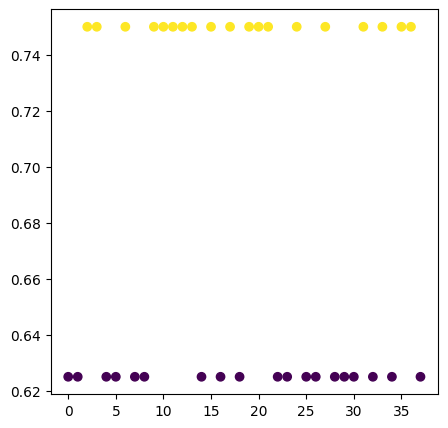

Balanced accuracy: 0.5
Mean balanced accuracy: 0.5009210526315789


[0.6052631578947368, 0.45, 0.48684210526315785, 0.46249999999999997, 0.5]

In [28]:
X_sessions = [session for patient in X_patients for session in patient]
y_sessions = [session for patient in y_patients for session in patient]

cv_test_alt(X_sessions, y_sessions, verbose=True, display=True)